In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
import pandas as pd
df = pd.read_csv("autotune_results.csv")
df_new = df[~(df["BlockRow"] == 0)]
mask = np.random.rand(len(df_new)) < 0.8
#df_train = df_new[mask]
#df_val = df_new[~mask]
#val_filenames = df_val["Name"].tolist()
# train_filenames = df_train["Name"].tolist()

data_dir = './sparse_pngs'
# train_dir = os.path.join(data_dir, "train")
# val_dir = os.path.join(data_dir, "val")


In [7]:
from shutil import copyfile
import glob
png_files = glob.glob('sparse_pngs/*.png')

# TODO : fix the training data where PNG files dont exist by same name
def copy_files(filenames):
    counter = 0
    ret_files = []
    df_names = []
    for f in filenames:
        fname = os.path.splitext(f)[0] + ".png"
        src_file = os.path.join(data_dir,fname)
        if (os.path.isfile(src_file)):
            #outfile = os.path.join(file_dir, fname)
            #copyfile(src_file, outfile)
            ret_files.append(src_file)
            df_names.append(f)
            counter = counter + 1
    print(counter)
    return df_names, ret_files
#train_files = copy_files(train_filenames, train_dir)
df_names, val_files = copy_files(df_new["Name"].tolist())

1205


In [9]:
from PIL import Image 

def pil_fn(f):
    im = Image.open(f).convert('L')
    im = im.resize((256,256))
    im_np = np.array(im).ravel()
    return im_np

np_array = [pil_fn(f) for f in val_files]

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print (np.shape(np_array))
tsne = TSNE(n_components=2).fit_transform(np_array)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
np_array_pca = decomposition.TruncatedSVD(n_components=64).fit_transform(np_array)
print (np_array_pca.shape)

(1205, 65536)
(1205, 64)


In [19]:
df_tmp = df_new[df_new["Name"].isin(df_names)]
df_tmp["Class"] = df_tmp["BlockRow"].astype(str) + "x" + df_tmp["BlockCol"].astype(str)


<ipython-input-19-0d32a2264fc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Class"] = df_tmp["BlockRow"].astype(str) + "x" + df_tmp["BlockCol"].astype(str)


In [20]:
from sklearn.ensemble import RandomForestClassifier
df_tmp['tx'] = tx
df_tmp['ty'] = ty

rf = RandomForestClassifier(n_estimators = 200, random_state = 0, class_weight='balanced')

<ipython-input-20-87d0ea10bf27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['tx'] = tx
<ipython-input-20-87d0ea10bf27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['ty'] = ty


In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
#skt = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
df_tmp['pca'] = np_array_pca.tolist()
df_tmp.head()

<ipython-input-21-11c7a1d03512>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['pca'] = np_array_pca.tolist()


,Name,MFLOPS_observed,MFLOPS_tuned,Time,Row,Col,BlockRow,BlockCol,Class,tx,ty,pca
2,ncvxqp1.rb,3338.00,2966.84,0.003967,12111,12111,1,1,1x1,0.214499,0.455998,"[62634.2858474423, -524.5455323254188, -1496.2..."
4,adder_dcop_59.rb,1454.89,1327.59,0.001859,1813,1813,1,1,1x1,0.393787,0.703700,"[60147.53571742065, 2283.5583176173154, 214.09..."
6,nsic.rb,1837.08,1448.40,0.001393,465,897,1,1,1x1,0.061419,0.442700,"[62927.141466947905, -1898.7306043222106, -440..."
8,adder_dcop_19.rb,1464.58,1343.07,0.002048,1813,1813,1,1,1x1,0.392237,0.681408,"[60627.71798204566, 1724.0808299529417, -113.8..."
10,bloweybq.rb,3515.89,3672.52,0.003631,10001,10001,2,2,2x2,0.305480,0.477169,"[64475.74596059877, -2809.5983030146162, 737.1..."


                            Name  MFLOPS_observed  MFLOPS_tuned      Time  \
812             Long_Coup_dt0.rb          3200.50       4951.48  2.091600   
1009            Cube_Coup_dt6.rb          3279.20       4988.07  2.991400   
1186                   steam2.rb          2118.29       4264.26  0.001679   
1276                 venkat25.rb          1594.44       2752.25  0.085158   
1365            Long_Coup_dt6.rb          3145.89       4950.92  2.132810   
1411  tumorAntiAngiogenesis_2.rb          2625.43       1394.65  0.001921   
2011                 venkat01.rb          1518.36       2735.03  0.094675   
2259            Cube_Coup_dt0.rb          3370.09       5036.35  2.993880   
2265                 venkat50.rb          1544.53       2829.56  0.074026   
2520                 bcsstk26.rb          3270.14       3519.37  0.002203   
2584               CoupCons3D.rb          1668.96       2876.78  0.953132   

          Row      Col  BlockRow  BlockCol Class        tx        ty  \
812

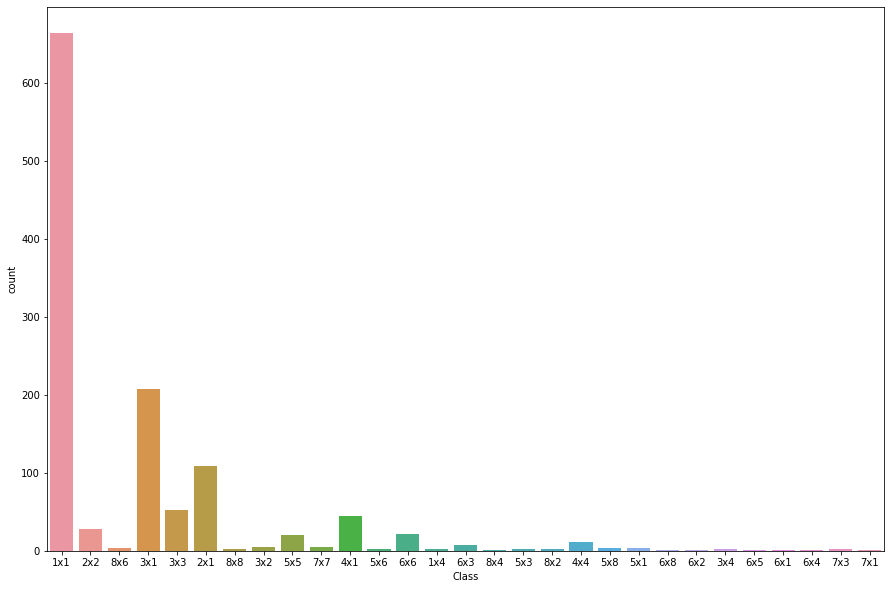

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(df_tmp["Class"], ax = ax)
print (df_tmp[df_tmp["Class"] == "4x4"])

In [27]:
train_set, test_set = train_test_split(df_tmp, test_size=0.2, random_state=0)
print(train_set.shape, test_set.shape)
model_tsne = rf.fit(train_set[['tx', 'ty']], train_set["Class"])
p = model_tsne.predict(test_set[['tx', 'ty']])
report = classification_report(test_set['Class'], p, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("classification_report.csv", "\t")

(964, 12) (241, 12)


/home/kulinseth/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kulinseth/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
train_set_pca, test_set_pca = train_test_split(np_array_pca, test_size=0.4,random_state=0)
model_pca = rf.fit(train_set_pca, train_set["Class"])
p = model_pca.predict(test_set_pca)
print(classification_report(test_set['Class'], p))

ValueError: operands could not be broadcast together with shapes (964,) (723,) (964,) 

In [30]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RuntimeError: Found 0 files in subfolders of: ./sparse_pngs/train
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



